# Final Project Demertzoglou Efstratios

## Importing the necessary libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neurolab as nl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import mode
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from ucimlrepo import fetch_ucirepo 





## Importing the BankNote dataset

In [3]:
# fetch dataset 
banknote_authentication = fetch_ucirepo(id=267) 
  
# data (as pandas dataframes) 
X = banknote_authentication.data.features 
y = banknote_authentication.data.targets 

# Combine X and y for easier preprocessing
df = pd.concat([X, y.squeeze().rename("target")], axis=1)

# Creating a copy for 'before' and 'after' comparisons
df_before = df.copy()

# metadata 
print(banknote_authentication.metadata) 
  
# variable information 
print(banknote_authentication.variables) 


{'uci_id': 267, 'name': 'Banknote Authentication', 'repository_url': 'https://archive.ics.uci.edu/dataset/267/banknote+authentication', 'data_url': 'https://archive.ics.uci.edu/static/public/267/data.csv', 'abstract': 'Data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1372, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Fri Feb 16 2024', 'dataset_doi': '10.24432/C55P57', 'creators': ['Volker Lohweg'], 'intro_paper': None, 'additional_info': {'summary': 'Data were extracted from images that were taken from genuine and forged banknote-like specimens.  For digitization, an industrial camera usually used for print inspection was used. The final im

## Step 2: Check for Outliers and Missing Values


In [4]:
# Step 2: Check for Outliers and Missing Values
# Outlier Detection & Removal using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to all numeric columns (excluding the target column)
for col in df.select_dtypes(include=np.number).columns[:-1]:
    df = remove_outliers(df, col)

# Check for Missing Values
if df.isnull().sum().any():
    # Replace missing values with the mean of their respective column
    df.fillna(df.mean(), inplace=True)

# Creating a copy for 'after' comparisons
df_after = df.copy()




### Showing before and after outlier and missing values removal

/tmp/ipykernel_3360/286926772.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(df_before.iloc[:, :-1].values, labels=df_before.columns[:-1])
/tmp/ipykernel_3360/286926772.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(df_after.iloc[:, :-1].values, labels=df_after.columns[:-1])


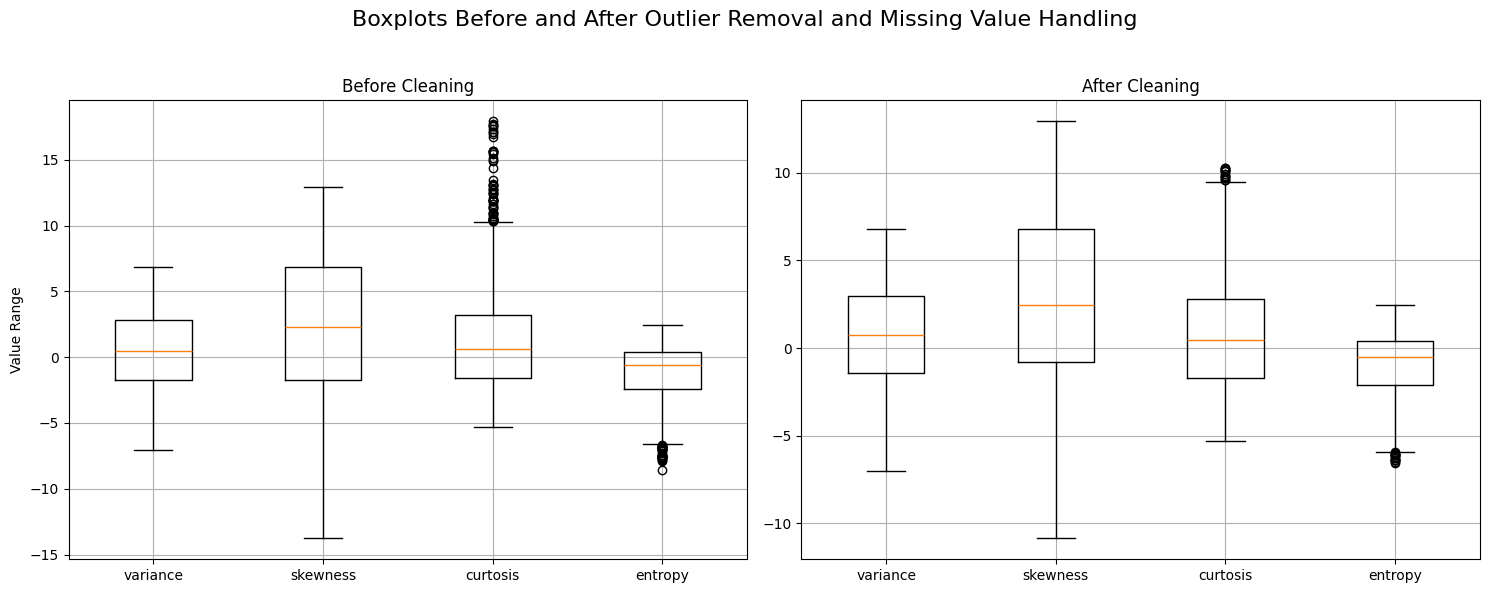

In [5]:
# Visualize Before and After with Boxplots
# Subplots for Before and After
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Boxplots Before and After Outlier Removal and Missing Value Handling", fontsize=16)

# Boxplot Before
axs[0].boxplot(df_before.iloc[:, :-1].values, labels=df_before.columns[:-1])
axs[0].set_title("Before Cleaning")
axs[0].set_ylabel("Value Range")
axs[0].grid(True)

# Boxplot After
axs[1].boxplot(df_after.iloc[:, :-1].values, labels=df_after.columns[:-1])
axs[1].set_title("After Cleaning")
axs[1].grid(True)

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
plt.show()

## Step 3: Data Preprocessing

### Normalizing data using MinMaxScaler

In [6]:
# Normalize features to [0, 1]
X = MinMaxScaler().fit_transform(X)

### Split Dataset into training and test set (70-30)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Verify the split
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 960 samples
Test set size: 412 samples


## KMeans to find optimal number of clusters

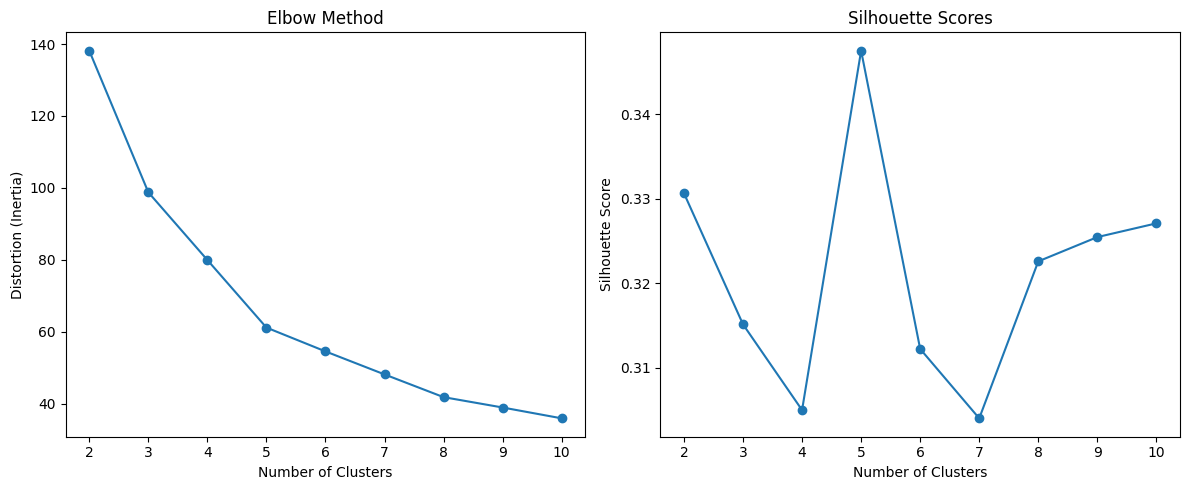

Optimal number of clusters based on silhouette score: 5


In [8]:
# Step 1: Elbow Method to Determine Optimal Number of Categories
def elbow_method(X, max_clusters=10):
    distortions = []
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    # Plot Elbow and Silhouette Score
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), distortions, marker='o')
    plt.title("Elbow Method")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Distortion (Inertia)")

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title("Silhouette Scores")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.tight_layout()
    plt.show()

    # Return the optimal number of clusters (based on the Elbow Method or Silhouette Score)
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    print(f"Optimal number of clusters based on silhouette score: {optimal_clusters}")
    return optimal_clusters


# Determine the number of categories using the Elbow Method
optimal_categories = elbow_method(X, max_clusters=10)

## NN training 

In [9]:
# Step 2: Create and Train the Neural Network
# Using the optimal number of categories from the Elbow Method
net = nl.net.newc(nl.tool.minmax(X_train), optimal_categories)

# Configure the training parameters
net.trainf = nl.train.train_wta  # Winner-Takes-All training function
error = net.train(X, epochs=3000, show=100, goal=1e-5, lr=0.3)

Epoch: 100; Error: 557.6492806737257;
Epoch: 200; Error: 557.6492806737257;
Epoch: 300; Error: 557.6492806737257;
Epoch: 400; Error: 557.6492806737257;
Epoch: 500; Error: 557.6492806737257;
Epoch: 600; Error: 557.6492806737257;
Epoch: 700; Error: 557.6492806737257;
Epoch: 800; Error: 557.6492806737257;
Epoch: 900; Error: 557.6492806737257;
Epoch: 1000; Error: 557.6492806737257;
Epoch: 1100; Error: 557.6492806737257;
Epoch: 1200; Error: 557.6492806737257;
Epoch: 1300; Error: 557.6492806737257;
Epoch: 1400; Error: 557.6492806737257;
Epoch: 1500; Error: 557.6492806737257;
Epoch: 1600; Error: 557.6492806737257;
Epoch: 1700; Error: 557.6492806737257;
Epoch: 1800; Error: 557.6492806737257;
Epoch: 1900; Error: 557.6492806737257;
Epoch: 2000; Error: 557.6492806737257;
Epoch: 2100; Error: 557.6492806737257;
Epoch: 2200; Error: 557.6492806737257;
Epoch: 2300; Error: 557.6492806737257;
Epoch: 2400; Error: 557.6492806737257;
Epoch: 2500; Error: 557.6492806737257;
Epoch: 2600; Error: 557.6492806737

## Plotting Training Results

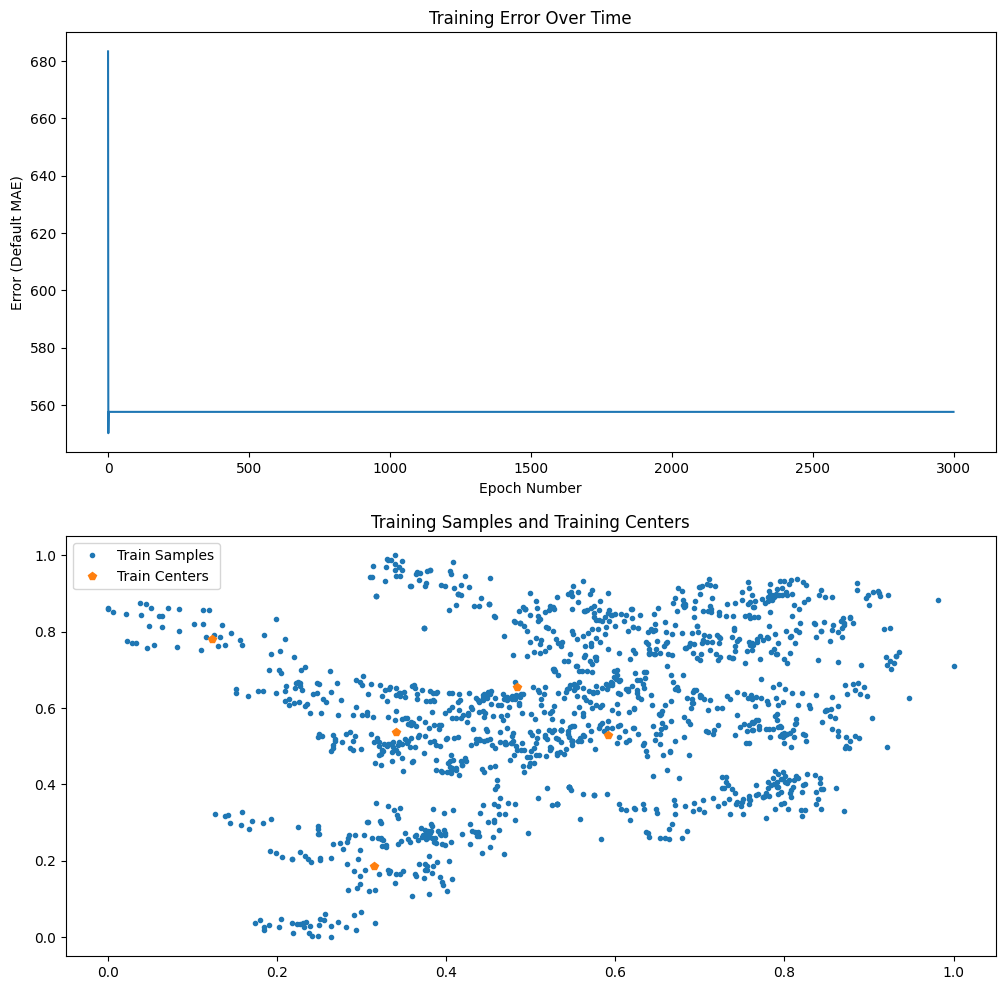

In [10]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(error)
plt.title("Training Error Over Time")
plt.xlabel("Epoch Number")
plt.ylabel("Error (Default MAE)")

# Visualize the clusters and training centers
w = net.layers[0].np['w']
plt.subplot(2, 1, 2)
plt.plot(X[:, 0], X[:, 1], '.', w[:, 0], w[:, 1], 'p')
plt.title("Training Samples and Training Centers")
plt.legend(['Train Samples', 'Train Centers'])
plt.show()

## Presenting to the NN the test set

In [11]:
# Step 5: Present Test Set to Neural Network
y_pred = net.sim(X_test)  # Predict on test set
y_pred_binary = np.argmax(y_pred, axis=1)  # Select the index of the max value for each prediction
y_test_array = y_test.squeeze().values if isinstance(y_test, pd.DataFrame) else y_test


## Mapping Clusters to True Classes

In [12]:
# Step 1: Map Clusters to True Classes
# Map predicted clusters to actual classes based on the majority class in each cluster

def map_clusters_to_classes(y_train, y_train_clusters):
    cluster_to_class_mapping = {}
    unique_clusters = np.unique(y_train_clusters)
    for cluster in unique_clusters:
        # Find the most frequent actual class within each cluster
        majority_class = mode(y_train[y_train_clusters == cluster]).mode[0]
        cluster_to_class_mapping[cluster] = majority_class
    return cluster_to_class_mapping

# Get predicted clusters for the training set
y_train_clusters = np.argmax(net.sim(X_train), axis=1)

# Create the mapping from clusters to true classes
cluster_to_class_mapping = map_clusters_to_classes(y_train, y_train_clusters)

# Step 2: Apply Mapping to Predictions
# Get predicted clusters for the test set
y_test_clusters = np.argmax(net.sim(X_test), axis=1)

# Map predicted clusters to actual classes
y_pred_mapped = np.array([cluster_to_class_mapping[cluster] for cluster in y_test_clusters])

## Calculating Accuracy

In [13]:
accuracy = accuracy_score(y_test, y_pred_mapped)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 75.24%


## Plotting Classified Patterns

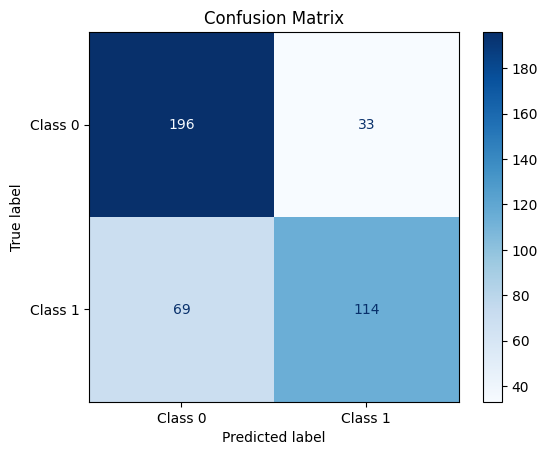

In [14]:
cm = confusion_matrix(y_test, y_pred_mapped)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Optimize 

### First Config test 50 min runtime

In [91]:
# Optimization configurations
neuron_configs = [5, 10, 15]  # Number of neurons in the hidden layer
layer_configs = [1, 2]  # Number of layers
learning_rates = [0.1, 0.2, 0.3]  # Learning rates
epoch_configs = [1000, 2000, 3000]  # Number of epochs

# Store results
optimization_results = []

# Optimization loop
for num_layers in layer_configs:
    for num_neurons in neuron_configs:
        for lr in learning_rates:
            for epochs in epoch_configs:
                print(f"\n=== Training NN: {num_layers} Layers, {num_neurons} Neurons, LR={lr}, Epochs={epochs} ===")
                
                # Define architecture
                layer_structure = [num_neurons] * num_layers + [1]  # Add output layer
                net = nl.net.newff(nl.tool.minmax(X_train), layer_structure)
                
                # Configure training parameters
                net.trainf = nl.train.train_gd  # Gradient Descent training function
                error = net.train(X_train, y_train.to_numpy().reshape(-1, 1), epochs=epochs, show=100, goal=1e-5, lr=lr)
                
                # Predict on the test set
                y_pred = net.sim(X_test).ravel()
                y_pred_binary = (y_pred > 0.5).astype(int)
                
                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred_binary)
                print(f"Test Accuracy: {accuracy * 100:.2f}%")
                
                # Store results
                optimization_results.append({
                    "Layers": num_layers,
                    "Neurons": num_neurons,
                    "Learning Rate": lr,
                    "Epochs": epochs,
                    "Test Accuracy (%)": round(accuracy * 100, 2)
                })

# Display results in a table
results_df = pd.DataFrame(optimization_results)
print("\n=== Optimization Results Table ===")
print(results_df)

# Save results to a CSV file
results_df.to_csv("nn_optimization_results.csv", index=False)


=== Training NN: 1 Layers, 5 Neurons, LR=0.1, Epochs=1000 ===
Epoch: 100; Error: 266.5;
Epoch: 200; Error: 266.5;
Epoch: 300; Error: 266.5;
Epoch: 400; Error: 266.5;
Epoch: 500; Error: 266.5;
Epoch: 600; Error: 266.5;
Epoch: 700; Error: 266.5;
Epoch: 800; Error: 266.5;
Epoch: 900; Error: 266.5;
Epoch: 1000; Error: 266.5;
The maximum number of train epochs is reached
Test Accuracy: 44.42%

=== Training NN: 1 Layers, 5 Neurons, LR=0.1, Epochs=2000 ===
Epoch: 100; Error: 1120.5;
Epoch: 200; Error: 1120.5;
Epoch: 300; Error: 1120.5;
Epoch: 400; Error: 1120.5;
Epoch: 500; Error: 1120.5;
Epoch: 600; Error: 1120.5;
Epoch: 700; Error: 1120.5;
Epoch: 800; Error: 1120.5;
Epoch: 900; Error: 1120.5;
Epoch: 1000; Error: 1120.5;
Epoch: 1100; Error: 1120.5;
Epoch: 1200; Error: 1120.5;
Epoch: 1300; Error: 1120.5;
Epoch: 1400; Error: 1120.5;
Epoch: 1500; Error: 1120.5;
Epoch: 1600; Error: 1120.5;
Epoch: 1700; Error: 1120.5;
Epoch: 1800; Error: 1120.5;
Epoch: 1900; Error: 1120.5;
Epoch: 2000; Error: 11

### Second Configuration Test 20 mins runtime

In [ ]:
# Optimization configurations
neuron_configs = [10, 15]  # Number of neurons in the hidden layer
layer_configs = [2, 3]  # Number of layers
learning_rates = [0.01, 0.2]  # Learning rates
epoch_configs = [1000, 5000]  # Number of epochs

# Store results
optimization_results_v2 = []

# Optimization loop
for num_layers in layer_configs:
    for num_neurons in neuron_configs:
        for lr in learning_rates:
            for epochs in epoch_configs:
                print(f"\n=== Training NN: {num_layers} Layers, {num_neurons} Neurons, LR={lr}, Epochs={epochs} ===")
                
                # Define architecture
                layer_structure = [num_neurons] * num_layers + [1]  # Add output layer
                net = nl.net.newff(nl.tool.minmax(X_train), layer_structure)
                
                # Configure training parameters
                net.trainf = nl.train.train_gd  # Gradient Descent training function
                error = net.train(X_train, y_train.to_numpy().reshape(-1, 1), epochs=epochs, show=250, goal=1e-5, lr=lr)
                
                # Predict on the test set
                y_pred = net.sim(X_test).ravel()
                y_pred_binary = (y_pred > 0.5).astype(int)
                
                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred_binary)
                print(f"Test Accuracy: {accuracy * 100:.2f}%")
                
                # Store results
                optimization_results_v2.append({
                    "Layers": num_layers,
                    "Neurons": num_neurons,
                    "Learning Rate": lr,
                    "Epochs": epochs,
                    "Test Accuracy (%)": round(accuracy * 100, 2)
                })

# Display results in a table
results_df_v2 = pd.DataFrame(optimization_results_v2)
print("\n=== Optimization Results Table ===")
print(results_df_v2)

# Save results to a CSV file
results_df_v2.to_csv("nn_optimization_results_v2.csv", index=False)


=== Training NN: 2 Layers, 10 Neurons, LR=0.01, Epochs=1000 ===
Epoch: 250; Error: 266.5;
Epoch: 500; Error: 266.5;
Epoch: 750; Error: 266.5;
Epoch: 1000; Error: 266.5;
The maximum number of train epochs is reached
Test Accuracy: 44.42%

=== Training NN: 2 Layers, 10 Neurons, LR=0.01, Epochs=5000 ===
Epoch: 250; Error: 266.49676250197945;
Epoch: 500; Error: 1120.4999995924572;
Epoch: 750; Error: 1120.4999995924231;
Epoch: 1000; Error: 1120.499999592389;
Epoch: 1250; Error: 1120.4999995923547;
Epoch: 1500; Error: 1120.4999995923206;
Epoch: 1750; Error: 1120.4999995922863;
Epoch: 2000; Error: 1120.4999995922522;
Epoch: 2250; Error: 1120.499999592218;
Epoch: 2500; Error: 1120.499999592184;
Epoch: 2750; Error: 1120.4999995921496;
Epoch: 3000; Error: 1120.4999995921153;
Epoch: 3250; Error: 1120.4999995920812;
Epoch: 3500; Error: 1120.4999995920468;
Epoch: 3750; Error: 1120.4999995920127;
Epoch: 4000; Error: 1120.4999995919786;
Epoch: 4250; Error: 1120.4999995919443;
Epoch: 4500; Error: 112

In [96]:
                
# Define architecture
layer_structure = [20] * 5 + [1]  # Add output layer
net = nl.net.newff(nl.tool.minmax(X_train), layer_structure)
                
# Configure training parameters
net.trainf = nl.train.train_gd  # Gradient Descent training function
error = net.train(X_train, y_train.to_numpy().reshape(-1, 1), epochs=10000, show=100, goal=1e-5, lr=0.01)
                
                # Predict on the test set
y_pred = net.sim(X_test).ravel()
y_pred_binary = (y_pred > 0.5).astype(int)
                
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
                
# Store results
optimization_results_v3 = []

optimization_results_v3.append({
"Layers": 5,
"Neurons": 20,
"Learning Rate": 0.01,
"Epochs": 10000,
"Test Accuracy (%)": round(accuracy * 100, 2)
})

Epoch: 100; Error: 266.4999432433245;
Epoch: 200; Error: 266.49994135696085;
Epoch: 300; Error: 266.4999393388184;
Epoch: 400; Error: 266.49993717449763;
Epoch: 500; Error: 266.4999348474142;
Epoch: 600; Error: 266.49993233836705;
Epoch: 700; Error: 266.4999296250003;
Epoch: 800; Error: 266.4999266811254;
Epoch: 900; Error: 266.4999234758617;
Epoch: 1000; Error: 266.4999199725331;
Epoch: 1100; Error: 266.49991612723846;
Epoch: 1200; Error: 266.4999118869757;
Epoch: 1300; Error: 266.4999071871486;
Epoch: 1400; Error: 266.4999019482043;
Epoch: 1500; Error: 266.499896071027;
Epoch: 1600; Error: 266.49988943051426;
Epoch: 1700; Error: 266.4998818664385;
Epoch: 1800; Error: 266.49987317015274;
Epoch: 1900; Error: 266.4998630647512;
Epoch: 2000; Error: 266.4998511745823;
Epoch: 2100; Error: 266.49983697678124;
Epoch: 2200; Error: 266.4998197210782;
Epoch: 2300; Error: 266.49979829064193;
Epoch: 2400; Error: 266.49977094620317;
Epoch: 2500; Error: 266.49973482040707;
Epoch: 2600; Error: 266.4

In [99]:
results_df_v3 = pd.DataFrame(optimization_results_v3)
print("\n=== Optimization Results Table ===")
print(results_df_v3)


=== Optimization Results Table ===
   Layers  Neurons  Learning Rate  Epochs  Test Accuracy (%)
0       5       20           0.01   10000              44.42


### Swapping training way:

Epoch: 100; Error: 533.0;
Epoch: 200; Error: 533.0;
Epoch: 300; Error: 533.0;
Epoch: 400; Error: 533.0;
Epoch: 500; Error: 533.0;
Epoch: 600; Error: 533.0;
Epoch: 700; Error: 533.0;
Epoch: 800; Error: 533.0;
Epoch: 900; Error: 533.0;
Epoch: 1000; Error: 533.0;
Epoch: 1100; Error: 533.0;
Epoch: 1200; Error: 533.0;
Epoch: 1300; Error: 533.0;
Epoch: 1400; Error: 533.0;
Epoch: 1500; Error: 533.0;
Epoch: 1600; Error: 533.0;
Epoch: 1700; Error: 533.0;
Epoch: 1800; Error: 533.0;
Epoch: 1900; Error: 533.0;
Epoch: 2000; Error: 533.0;
Epoch: 2100; Error: 533.0;
Epoch: 2200; Error: 533.0;
Epoch: 2300; Error: 533.0;
Epoch: 2400; Error: 533.0;
Epoch: 2500; Error: 533.0;
Epoch: 2600; Error: 533.0;
Epoch: 2700; Error: 533.0;
Epoch: 2800; Error: 533.0;
Epoch: 2900; Error: 533.0;
Epoch: 3000; Error: 533.0;
The maximum number of train epochs is reached


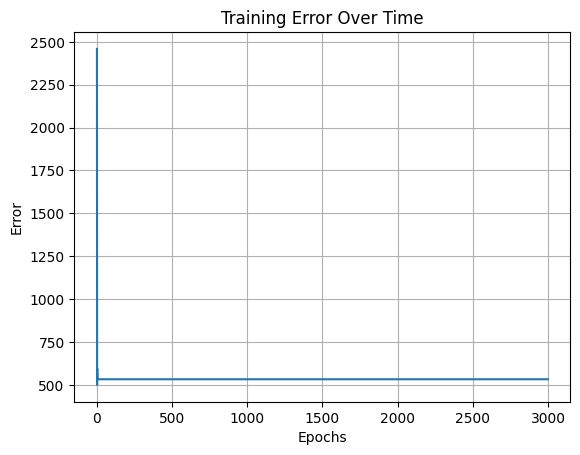

Test Accuracy: 50.49%


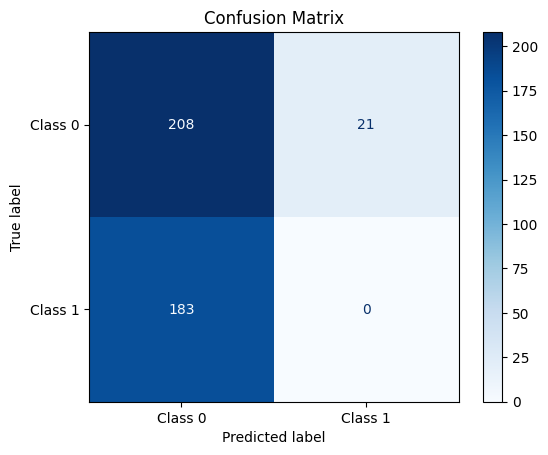

In [114]:
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE


# Balance the dataset using SMOTE
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# One-hot encode the balanced target
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train_balanced.to_numpy().reshape(-1, 1))

# Define the architecture
num_classes = y_train_encoded.shape[1]
layer_structure = [30, 15, num_classes]  # Increased neurons for better capacity
net = nl.net.newff(nl.tool.minmax(X_train_scaled), layer_structure)

# Configure the training parameters
net.trainf = nl.train.train_gd  # Gradient descent training function
error = net.train(X_train_scaled, y_train_encoded, epochs=3000, show=100, goal=1e-5, lr=0.01)

# Plot the training error over epochs
plt.plot(error)
plt.title("Training Error Over Time")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.grid()
plt.show()

# Predict on the test set
y_pred = net.sim(X_test_scaled)  # Predict probabilities for each class
y_pred_classes = np.argmax(y_pred, axis=1)  # Select the class with the highest probability

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# FINAL WORKING RESULT 99.51% SOFTMAX

Epoch: 100; Error: 266.3466926471925;
Epoch: 200; Error: 265.3868996270153;
Epoch: 300; Error: 263.95639324731997;
Epoch: 400; Error: 260.92262893145687;
Epoch: 500; Error: 251.34889357685182;
Epoch: 600; Error: 241.0700114351505;
Epoch: 700; Error: 232.9934459911608;
Epoch: 800; Error: 207.1428049912238;
Epoch: 900; Error: 180.22626318365462;
Epoch: 1000; Error: 139.39276923909546;
Epoch: 1100; Error: 98.41140976224389;
Epoch: 1200; Error: 66.41718866014939;
Epoch: 1300; Error: 49.41073840324144;
Epoch: 1400; Error: 41.60465067119533;
Epoch: 1500; Error: 36.58268122832999;
Epoch: 1600; Error: 32.83456767260588;
Epoch: 1700; Error: 29.915985914870102;
Epoch: 1800; Error: 27.605831466694355;
Epoch: 1900; Error: 25.757706924262592;
Epoch: 2000; Error: 24.262159254702627;
Epoch: 2100; Error: 23.0340865314449;
Epoch: 2200; Error: 22.007377307203065;
Epoch: 2300; Error: 21.131496196789094;
Epoch: 2400; Error: 20.368544224955293;
Epoch: 2500; Error: 19.690585298747166;
Epoch: 2600; Error: 19

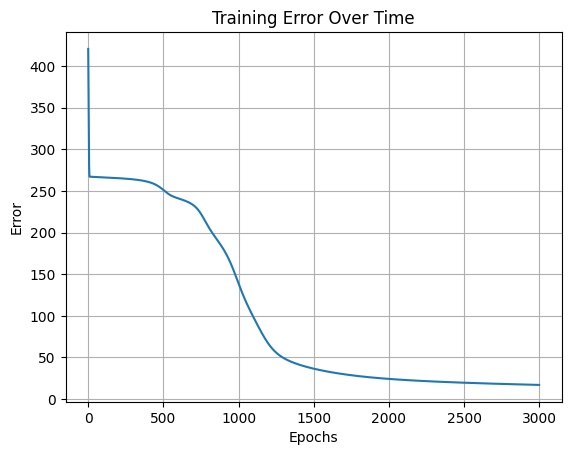

Test Accuracy: 99.51%


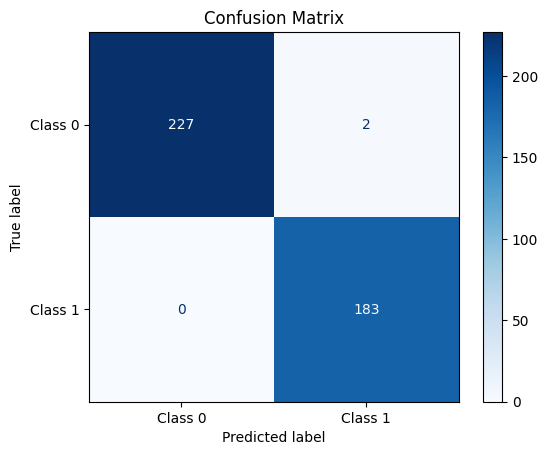

In [15]:
# Balance the dataset using SMOTE
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# One-hot encode the balanced target
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train_balanced.to_numpy().reshape(-1, 1))

# Define the architecture
num_classes = y_train_encoded.shape[1]
layer_structure = [50, 30, num_classes]  # Increased neurons for better capacity
net = nl.net.newff(nl.tool.minmax(X_train_scaled), layer_structure)

# Use TanSig (tanh) activation function for hidden layers
for layer in net.layers[:-1]:  # Skip the last layer (output layer)
    layer.transf = nl.trans.SoftMax()
# Configure the training parameters
net.trainf = nl.train.train_gd  # Gradient descent training function
error = net.train(X_train_scaled, y_train_encoded, epochs=3000, show=100, goal=1e-5, lr=0.001)  # Reduced learning rate

# Plot the training error over epochs
plt.plot(error)
plt.title("Training Error Over Time")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.grid()
plt.show()

# Predict on the test set
y_pred = net.sim(X_test_scaled)  # Predict probabilities for each class
y_pred_classes = np.argmax(y_pred, axis=1)  # Select the class with the highest probability

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Experimenting with different train test splits

In [22]:
# Function to train and evaluate the model with a given train-test split
def train_and_evaluate(split_ratio):
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1 - split_ratio, random_state=42
    )
    
    # Balance the dataset using SMOTE
    smote = SMOTE()
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)

    # One-hot encode the balanced target
    encoder = OneHotEncoder(sparse_output=False)
    y_train_encoded = encoder.fit_transform(y_train_balanced.to_numpy().reshape(-1, 1))

    # Define the architecture
    num_classes = y_train_encoded.shape[1]
    layer_structure = [50, 30, num_classes]  # Increased neurons for better capacity
    net = nl.net.newff(nl.tool.minmax(X_train_scaled), layer_structure)

    # Use TanSig (tanh) activation function for hidden layers
    for layer in net.layers[:-1]:  # Skip the last layer (output layer)
        layer.transf = nl.trans.SoftMax()
        # Configure the training parameters
    net.trainf = nl.train.train_gd  # Gradient descent training function
    error = net.train(X_train_scaled, y_train_encoded, epochs=3000, show=100, goal=1e-5, lr=0.001)  # Reduced learning rate

    # Predict on the test set
    y_pred = net.sim(X_test_scaled)  # Predict probabilities for each class
    y_pred_classes = np.argmax(y_pred, axis=1)  # Select the class with the highest probability

    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_pred_classes)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        # Plot the training error over epochs
    # Enhanced plot with minimum error and accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(error, label="Training Error", color="blue")
    plt.axhline(y=min(error), color="red", linestyle="--", label=f"Min Error: {min(error):.4f}")
    plt.title("Training Error Over Time")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend(loc="upper right")
    plt.grid()
    plt.annotate(f"Accuracy: {test_accuracy * 100:.2f}%",xy=(len(error) - 100, min(error) + 50),  color="green", fontsize=12)
    plt.show()

    return test_accuracy




Epoch: 100; Error: 187.16091081957615;
Epoch: 200; Error: 185.26412602690493;
Epoch: 300; Error: 180.63758724825257;
Epoch: 400; Error: 160.785123819087;
Epoch: 500; Error: 127.33145418618305;
Epoch: 600; Error: 109.50602270007235;
Epoch: 700; Error: 89.39217249415327;
Epoch: 800; Error: 69.0715044652718;
Epoch: 900; Error: 53.37469297572192;
Epoch: 1000; Error: 42.45572055845788;
Epoch: 1100; Error: 35.13820547132748;
Epoch: 1200; Error: 30.709396524047627;
Epoch: 1300; Error: 28.23714152125943;
Epoch: 1400; Error: 26.7374462199756;
Epoch: 1500; Error: 25.65740857961913;
Epoch: 1600; Error: 24.793835128857303;
Epoch: 1700; Error: 24.079463583200365;
Epoch: 1800; Error: 23.482563576474313;
Epoch: 1900; Error: 22.979813187238612;
Epoch: 2000; Error: 22.551952482387954;
Epoch: 2100; Error: 22.183517528667444;
Epoch: 2200; Error: 21.86251848139301;
Epoch: 2300; Error: 21.579824174623713;
Epoch: 2400; Error: 21.328513727440516;
Epoch: 2500; Error: 21.10332271974476;
Epoch: 2600; Error: 20.

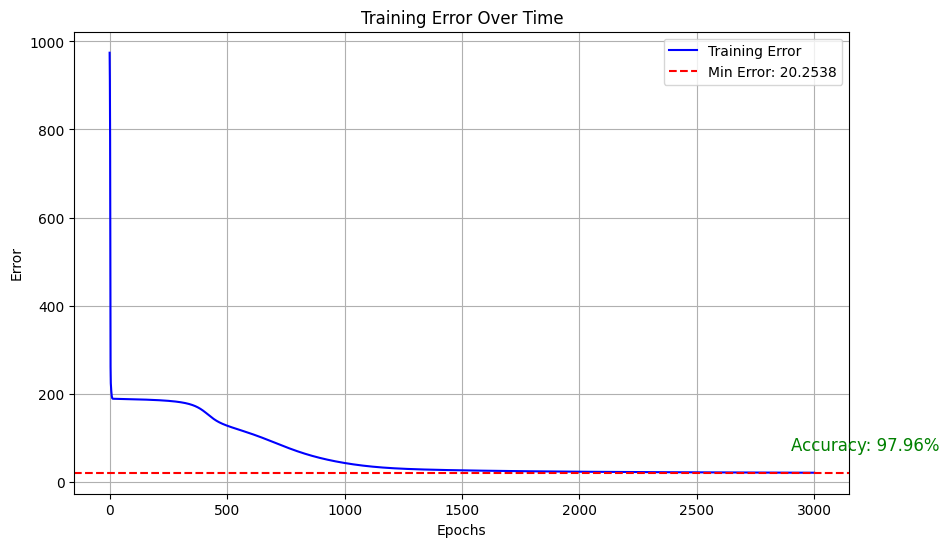

Epoch: 100; Error: 228.72780596408575;
Epoch: 200; Error: 228.06904470706843;
Epoch: 300; Error: 227.0615886439851;
Epoch: 400; Error: 225.23991162403962;
Epoch: 500; Error: 220.97648944834424;
Epoch: 600; Error: 203.90361312968656;
Epoch: 700; Error: 130.81314820653543;
Epoch: 800; Error: 90.38381630950715;
Epoch: 900; Error: 68.00222171885156;
Epoch: 1000; Error: 51.07102561305706;
Epoch: 1100; Error: 40.8400062788086;
Epoch: 1200; Error: 35.12505114688206;
Epoch: 1300; Error: 31.634005235509076;
Epoch: 1400; Error: 29.20711017905714;
Epoch: 1500; Error: 27.361918252550097;
Epoch: 1600; Error: 25.879010392829215;
Epoch: 1700; Error: 24.64139605002507;
Epoch: 1800; Error: 23.57887345243364;
Epoch: 1900; Error: 22.64609615608066;
Epoch: 2000; Error: 21.81225812282313;
Epoch: 2100; Error: 21.055512422890924;
Epoch: 2200; Error: 20.3596519518144;
Epoch: 2300; Error: 19.712032906959518;
Epoch: 2400; Error: 19.102267232581738;
Epoch: 2500; Error: 18.521426716797276;
Epoch: 2600; Error: 17.

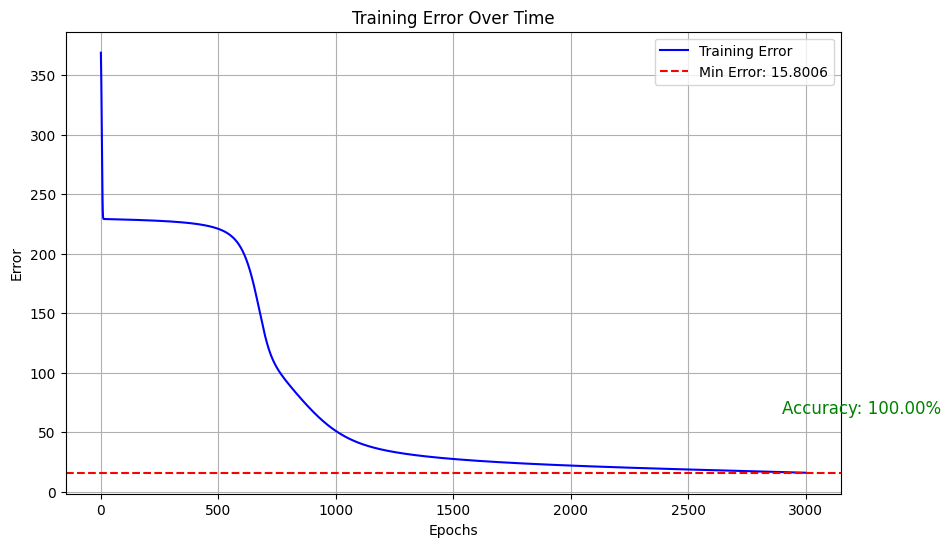

Epoch: 100; Error: 304.2912804133947;
Epoch: 200; Error: 299.1724162716037;
Epoch: 300; Error: 273.01447772209923;
Epoch: 400; Error: 150.8868103346639;
Epoch: 500; Error: 75.84423082212217;
Epoch: 600; Error: 115.6823217307745;
Epoch: 700; Error: 64.79295511503855;
Epoch: 800; Error: 45.055309614293606;
Epoch: 900; Error: 35.43303139835842;
Epoch: 1000; Error: 31.504674650768465;
Epoch: 1100; Error: 30.25283384015856;
Epoch: 1200; Error: 29.27368325938699;
Epoch: 1300; Error: 28.384990592140653;
Epoch: 1400; Error: 27.546807658165747;
Epoch: 1500; Error: 26.741620434861026;
Epoch: 1600; Error: 25.961496715014952;
Epoch: 1700; Error: 25.202766017576565;
Epoch: 1800; Error: 24.463550220660995;
Epoch: 1900; Error: 23.742506068707783;
Epoch: 2000; Error: 23.038143574127226;
Epoch: 2100; Error: 22.348447461674333;
Epoch: 2200; Error: 21.670675912401578;
Epoch: 2300; Error: 21.001284625087884;
Epoch: 2400; Error: 20.335976253704786;
Epoch: 2500; Error: 19.66992393755278;
Epoch: 2600; Error:

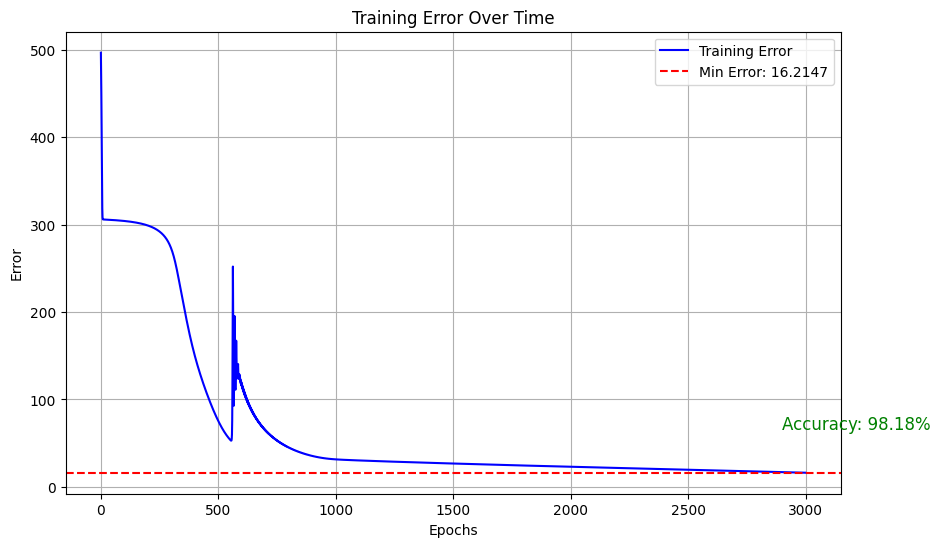

Epoch: 100; Error: 341.5495822263079;
Epoch: 200; Error: 338.8003943743821;
Epoch: 300; Error: 330.6738420066732;
Epoch: 400; Error: 293.64322103664017;
Epoch: 500; Error: 226.9609583742236;
Epoch: 600; Error: 59.92607111214312;
Epoch: 700; Error: 112.53177922069489;
Epoch: 800; Error: 57.43875862559039;
Epoch: 900; Error: 38.6728809809224;
Epoch: 1000; Error: 30.994635756383847;
Epoch: 1100; Error: 28.335839489112622;
Epoch: 1200; Error: 27.013401320591555;
Epoch: 1300; Error: 25.928769558421276;
Epoch: 1400; Error: 24.973189057699127;
Epoch: 1500; Error: 24.098908386635934;
Epoch: 1600; Error: 23.28262106122233;
Epoch: 1700; Error: 22.512265088525222;
Epoch: 1800; Error: 21.781255074155062;
Epoch: 1900; Error: 21.08577151751289;
Epoch: 2000; Error: 20.423394573745917;
Epoch: 2100; Error: 19.792384801949282;
Epoch: 2200; Error: 19.19130191153731;
Epoch: 2300; Error: 18.618809605503785;
Epoch: 2400; Error: 18.07358473081368;
Epoch: 2500; Error: 17.55428402662031;
Epoch: 2600; Error: 17

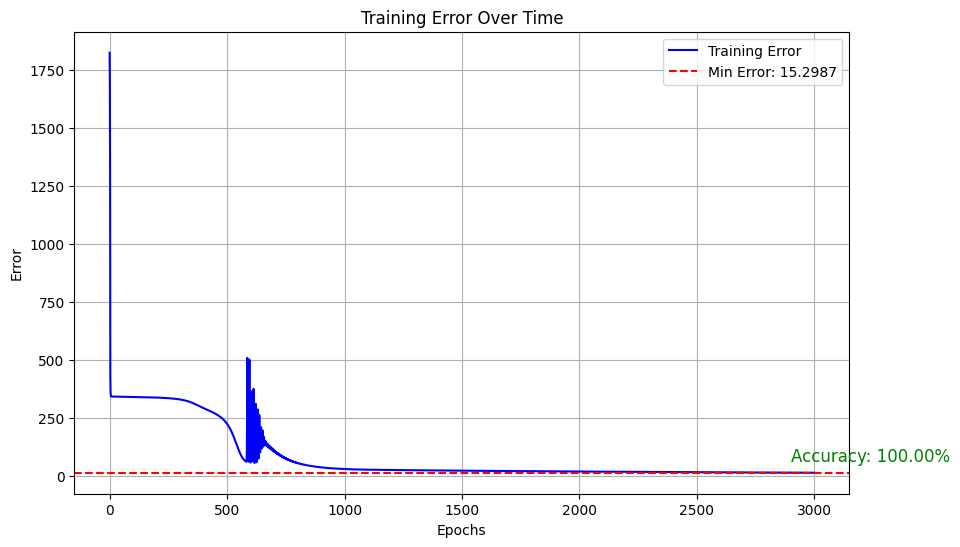

  Split Ratio  Test Accuracy (%)
0     50%-50%           0.979592
1     60%-40%           1.000000
2     80%-19%           0.981818
3      90%-9%           1.000000


In [23]:
# Define train-test split ratios
split_ratios = [0.5, 0.6, 0.8, 0.9]

# Run training and evaluation for each split ratio
results = []
for split_ratio in split_ratios:
    accuracy = train_and_evaluate(split_ratio)
    results.append({"Split Ratio": f"{int(split_ratio * 100)}%-{int((1 - split_ratio) * 100)}%", "Test Accuracy (%)": accuracy})

# Convert results to a DataFrame for better visualization
results_df_v4 = pd.DataFrame(results)
print(results_df_v4)

# Save results to a CSV file
results_df_v4.to_csv("train_test_split_results.csv", index=False)